# Generating Adversarial Example

This notebook demonstrates how you can find adversarial examples for a pre-trained example network on the MNIST dataset.

I have used `Gurobi` solver and it performance is significantly faster than other options. 

The `Images` package is only necessary for visualizing the MNIST images.

In [1]:
using MIPVerify
using Gurobi
using Images

┌ Info: Recompiling stale cache file C:\Users\BV SAMEER KUMAR\.julia\compiled\v1.2\MIPVerify\VXcUH.ji for MIPVerify [e5e5f8be-2a6a-5994-adbb-5afbd0e30425]
└ @ Base loading.jl:1240


ArgumentError: ArgumentError: Package FileIO not found in current path:
- Run `import Pkg; Pkg.add("FileIO")` to install the FileIO package.


## Setup

### MNIST dataset

We start by loading the MNIST dataset. The data is provided as a Julia `struct` for easy access. The training images and test images are provided as a 4-dimensional array of size `(num_samples, height, width, num_channels)`.

In [2]:
mnist = MIPVerify.read_datasets("MNIST")

mnist:
  `train`: {LabelledImageDataset}
    `images`: 60000 images of size (28, 28, 1), with pixels in [0.0, 1.0].
    `labels`: 60000 corresponding labels, with 10 unique labels in [0, 9].
  `test`: {LabelledImageDataset}
    `images`: 10000 images of size (28, 28, 1), with pixels in [0.0, 1.0].
    `labels`: 10000 corresponding labels, with 10 unique labels in [0, 9].

In [3]:
mnist.train

{LabelledImageDataset}
    `images`: 60000 images of size (28, 28, 1), with pixels in [0.0, 1.0].
    `labels`: 60000 corresponding labels, with 10 unique labels in [0, 9].

In [4]:
size(mnist.train.images)

(60000, 28, 28, 1)

We can use `Images.colorview` to preview these images. 

In [5]:
mnist.train.labels

60000-element Array{UInt8,1}:
 0x05
 0x00
 0x04
 0x01
 0x09
 0x02
 0x01
 0x03
 0x01
 0x04
 0x03
 0x05
 0x03
    ⋮
 0x07
 0x08
 0x09
 0x02
 0x09
 0x05
 0x01
 0x08
 0x03
 0x05
 0x06
 0x08

### Sample Neural Network

Import a sample pre-trained neural network. 

In [6]:
n1 = MIPVerify.get_example_network_params("MNIST.n1")

sequential net MNIST.n1
  (1) Flatten(): flattens 4 dimensional input, with dimensions permuted according to the order [4, 3, 2, 1]
  (2) Linear(784 -> 40)
  (3) ReLU()
  (4) Linear(40 -> 20)
  (5) ReLU()
  (6) Linear(20 -> 10)


`MIPVerify.frac_correct` lets you to verify that the network has a reasonable accuracy on the test set of 96.95%.

In [7]:
MIPVerify.frac_correct(n1, mnist.test, 10000)

Computing fraction correct...100%|██████████████████████| Time: 0:00:03


0.9695

We feed the first image into the neural net, obtaining the activations of the final softmax layer. 

Note that the image must be specified as a 4-dimensional array with size `(1, height, width, num_channels)`. There is a helper function `MIPVerify.get_image` that extracts the image from the dataset while preserving all four dimensions.

In [8]:
sample_image = MIPVerify.get_image(mnist.test.images, 1)

1×28×28×1 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

...

[:, :, 26, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 27, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 28, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [9]:
output_activations = sample_image |> n1

10-element Array{Float64,1}:
 -0.02074390040759505 
 -0.017499541361042703
  0.16707187742051954 
 -0.05323712887827292 
 -0.019291011852467455
 -0.07951546424946399 
  0.06191130931372918 
  4.833970937815984   
  0.46706000134294867 
  0.40145201599055125 

The category that has the largest activation is category 8, corresponding to a label of 7. Which means that the image we saw was of digit 7.

In [10]:
(output_activations |> MIPVerify.get_max_index) - 1

7

This matches the true label.

In [11]:
MIPVerify.get_label(mnist.test.labels, 1)

7

## Finding an Adversarial Example

We now try to find an adversarial example for the first image on `n1`, setting the target category as index `10` (corresponding to a true label of 9). Here we are trying to find an adversarial example that is does the following: if give adversarial as input to the nerual network we expect it ouput digit label as 7 but it instead it will tell us that the image label is 9. 

In [12]:
target_label_index = 10
d = MIPVerify.find_adversarial_example(n1, sample_image, target_label_index, GurobiSolver())

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Rebuilding model from scratch. This may take some time as we determine upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00
  Imposing relu constraint: 100%|███████████████████████| Time: 0:00:00
  Calculating upper bounds:  10%|███                    |  ETA: 0:00:20

Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:01:01
  Calculating lower bounds: 100%|███████████████████████| Time: 0:01:21


[notice | MIPVerify]: The model built will be cached and re-used for future solves, unless you explicitly set rebuild=true.
Academic license - for non-commercial use only
Optimize a model with 3385 rows, 3256 columns and 71132 nonzeros
Variable types: 3196 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [4e-03, 7e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R1024 by 1.000000000

Presolve removed 2956 rows and 2227 columns
Presolve time: 0.27s
Presolved: 429 rows, 1029 columns, 61365 nonzeros
Variable types: 969 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 213 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    4          -    0.0

Dict{Any,Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 71.3779
  :TotalTime          => 227.83
  :PerturbedInput     => [:, :, 1, 1] =…
  :Perturbation       => [:, :, 1, 1] =…
  :TighteningApproach => "mip"
  :PerturbationFamily => unrestricted
  :SolveStatus        => :Optimal
  :Model              => Minimization problem with:…
  :Output             => JuMP.GenericAffExpr{Float64,JuMP.Variable}[-0.01206386…
  :PredictedIndex     => 8

In [13]:
using JuMP

perturbed_sample_image = getvalue(d[:PerturbedInput])

1×28×28×1 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

...

[:, :, 26, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 27, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 28, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

As a sanity check, we feed the perturbed image into the neural net and inspect the activation in the final layer. We verify that the perturbed image does maximize the activation of the target label index, which is 10.

In [14]:
perturbed_sample_image |> n1

10-element Array{Float64,1}:
  1.0519768491269543 
  0.78534384834018   
  0.3138067335298753 
  0.4270109980815697 
  0.3697289881957214 
  0.25614527786295416
  0.6662295473279827 
  4.567066220573279  
 -0.14798446025766632
  4.567066220573276  

We visualize the perturbed image and compare it to the original image. Since we are minimizing the L1-norm, changes are made to only a few pixels, but the magnitude of these changes are large (and noticeable).

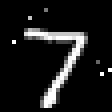

In [15]:
img = colorview(Gray, perturbed_sample_image[1, :, :, 1])

In [35]:
new_img = imresize(img; ratio = 10.0)
save("3.png", new_img)

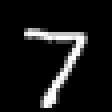

In [36]:
img = colorview(Gray, sample_image[1, :, :, 1])

In [37]:
new_img = imresize(img; ratio = 10.0)
save("4.png", new_img)